In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("alves_lada_nature_data.csv")
df.head()
radius_arcsec = np.asarray(df['radius_arcsec'])
visual_extinction = np.asarray(df['visual_extinction'])

$\newcommand{\vec}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

## Numerical solution to Lane-Emden equation.

### 1. Isothermal sphere in hydrostatic equilibrium.

* momentum equation: $\quad \rho \frac{d\vec{v}}{dt} + \vec{\nabla}P + \rho \vec{\nabla} \Phi = 0 \quad \longrightarrow \quad \frac{1}{\rho} \vec{\nabla}P = -\vec{\nabla} \Phi \quad$ (in hydrostatic equilibrium).
* gradient in spherical coordinates: $\quad \vec{\nabla} = \left( \frac{\partial}{\partial r} \vec{\hat{r}} + \frac{1}{r} \frac{\partial}{\partial \theta} \vec{\hat{\theta}} + \frac{1}{r \sin \theta} \frac{\partial}{\partial \phi} \vec{\hat{\phi}} \right) = \frac{d}{dr} \vec{\hat{r}} \quad$ (by spherical symmetry).
* isothermal sphere: $\quad P = c_s^2 \rho \quad \longrightarrow \quad \frac{1}{\rho} \frac{dP}{dr} = \frac{c_s^2}{\rho} \frac{d\rho}{dr} = c_s^2 \frac{d \ln \rho}{dr}$.
* hydrostatic equilibrium for isothermal sphere: $\quad \frac{1}{\rho} \vec{\nabla}P = -\vec{\nabla} \Phi \quad \longrightarrow \quad c_s^2 \frac{d \ln \rho}{dr} = -\frac{d\Phi}{dr}$.
* Poisson equation with spherical symmetry: $\quad \vec{\nabla}^2 \Phi = 4 \pi G \rho \quad \longrightarrow \quad \frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d\Phi}{dr} \right) = 4 \pi G \rho$.  

### 2. Lane-Emden equation.
Let $\xi = (\sqrt{4 \pi G \rho_c}/c_s) r$ be the dimensionless radial parameter, and let $\psi = -\ln(\rho/\rho_c)$ be the scaled gravitational potential,
$$ c_s^2 \frac{d \ln \rho}{dr} = -\frac{d\Phi}{dr} \quad \longrightarrow \quad c_s^2 \int_0^r \frac{d \ln \rho}{dr} = - \int_0^r \frac{d\Phi}{dr} \quad \longrightarrow \quad \Phi(r) = -c_s^2 \ln \left(\frac{\rho}{\rho_c} \right) \quad \longrightarrow \quad \psi(\xi) = \frac{\Phi(r)}{c_s^2}, $$
where $\rho_c$ is the central density. Using the new variable $\xi$ in place of $r$,
$$ \frac{d}{dr} = \frac{\sqrt{4 \pi G \rho_c}}{c_s} \frac{d}{d\xi} \quad \text{and} \quad \frac{d}{dr}\left( r^2 \frac{d }{dr} \right) = \frac{\sqrt{4 \pi G \rho_c}}{c_s} \frac{d}{d\xi}\left( \frac{c_s^2}{4 \pi G \rho_c} \frac{\sqrt{4 \pi G \rho_c}}{c_s} \xi^2 \frac{d}{d\xi} \right) = \frac{d}{d\xi} \left( \xi^2 \frac{d}{d\xi} \right). $$
The Poisson equation becomes the Lane-Emden equation:
$$ -\frac{c_s^2}{4 \pi G \rho_c} \bigg[ \frac{1}{r^2} \frac{d}{dr} \ln \left( \frac{\rho}{\rho_c} \right) \bigg] = \frac{\rho}{\rho_c} \quad \longrightarrow \quad \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\psi}{d\xi} \right)= e^{-\psi}. $$

### 3. Numerical solution for $\psi(x)$.
Write the second-order ODE in terms of two coupled ODEs.
$$ \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\psi}{d\xi} \right)= e^{-\psi} \quad \longrightarrow \quad \frac{d\psi}{d\xi} = \frac{y}{\xi^2}, \quad \frac{dy}{d\xi} = \xi^2 e^{-\psi(\xi)}.$$
Applying the boundary conditions $\psi(0) = 0$ and $d\psi(0)/d\xi = 0$, we can numerically integrate
$$ y(\xi) = \int_0^{\xi} \xi^2 e^{-\psi(\xi)} d\xi, \quad \psi(\xi) = \int_0^{\xi} \frac{1}{\xi^2} y d\xi. $$

In [3]:
# Numerical solution to Lane-Emden equation.
dxi = 0.02
N   = 500

xi  = 0.02
y1  = 0.0
psi = 0.0

xi_sol  = [0.]
psi_sol = [0.]

for i in range(N):
    y1  += xi**2 * np.exp(-psi) * dxi
    psi += y1/xi**2 * dxi
    xi_sol.append(xi)
    psi_sol.append(psi)
    xi  += dxi
    
rho_contrast = np.exp(-np.asarray(psi_sol))

In [4]:
temp = 16. # Kelvin
distance = 125. * 3.086e16 # metre
k_B = 1.38e-23
m_H2 = 2e-3/6.022e23 # kg
cs = np.sqrt(k_B * temp / m_H2) # m/s
G = 6.67e-11

print("cs = {0:.3e}".format(cs))

cs = 2.578e+02


## Alves, Lada, & Lada 2001, Nature, 409, 159
* $\xi_{\rm max} = 6.9 \; (\pm \; 0.2) \quad \longrightarrow \quad \rho_R/\rho_c = 6.030 \times 10^{-2}$.  
* "extinction profile in Fig. 2 is the two-dimensional projection of the cloud volume density profile function $\rho(r)$, where $r$ is the radial distance from the center of the cloud."

In [5]:
colden = np.zeros((N+1,N+1))
for i in range(N+1): # for xi_max
    for j in range(N+1): # for xi_x
        xi_x = xi_sol[j]
        integral = 0
        for k in range(j+1,i+1): # for dummy xi
            integral += rho_contrast[k] * xi_sol[k] * dxi / np.sqrt(xi_sol[k]**2 - xi_x**2)
        colden[i,j] = 2*cs * np.sqrt(1/(4*np.pi*G))*integral * 1000/1e4    # gram/cm^2

In [12]:
df_rau = radius_arcsec * distance / 3.086e16
data_len = df_rau.shape[0]
num = 1
rms_error = np.zeros((num, N+1))

rhoc_base = 6.2e-16
drhoc = 5e-18
rho_c = [rhoc_base+i*drhoc for i in range(num)]
for h in range(num):
    radius = np.asarray(xi_sol) * cs / np.sqrt(4.*np.pi*G*rho_c[h]) * 6.68e-12 # AU
    vis = colden * np.sqrt(rho_c[h]) / (2*1.926e-3)
    for i in range(N+1):
        error = 0
        for j in range(data_len):
            idx_radius = np.argmin(np.abs(radius - df_rau[j]))
            sim_vis = vis[i,idx_radius]
            error += np.power(visual_extinction[j] - sim_vis, 2)
        rms_error[h,i] = np.sqrt(error)
idx_xi_close = np.unravel_index(rms_error.argmin(), rms_error.shape)
print(idx_xi_close[0])
rho_center = rho_c[idx_xi_close[0]]
idx_xi = idx_xi_close[1]
print(idx_xi)
print(rho_center)

0
264
6.2e-16


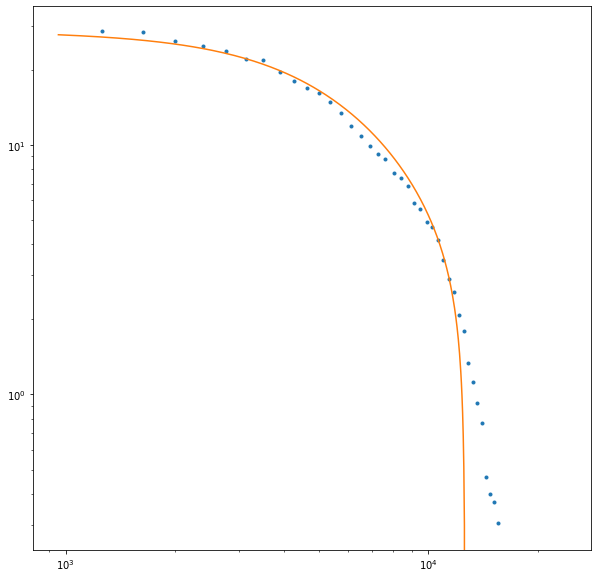

In [13]:
radius_final = np.asarray(xi_sol) * cs / np.sqrt(4.*np.pi*G*rho_center) * 6.68e-12 # AU
vis_final = colden * np.sqrt(rho_center) / (2*1.926e-3)
plt.figure(figsize=(10,10))
plt.plot(df_rau, visual_extinction, '.')
plt.xscale('log')
plt.yscale('log')
plt.plot(radius_final[20:], vis_final[idx_xi,20:])
plt.show()

In [14]:
radius_final[idx_xi]

12615.416795813087

In [15]:
rho_contrast[idx_xi]

0.11286580216747985

In [16]:
xi_sol[idx_xi]

5.279999999999975

In [11]:
idx_xi_max = np.argmin(np.abs(np.asarray(xi_sol) - 6.9))
rho_contrast[idx_xi_max]

0.0597826371882318